In [1]:
import torch

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU is available: {gpu_name}")
else:
    print("No GPU is available.")

GPU is available: Quadro RTX 5000


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Project 5B: Training Your Own Diffusion Model!

## Setup environment

In [3]:
# We recommend using these utils.
# https://google.github.io/mediapy/mediapy.html
# https://einops.rocks/
!pip install mediapy einops --quiet

In [45]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
from typing import Union, Optional


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Part 1: Training a Single-step Denoising UNet


## Implementing Simple and Composed Ops

In [7]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)

        

        
        

class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.downconv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.downconv(x)
    
    
    
    
    


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.upconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.upconv(x)
    
    
    
    


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.AvgPool2d(kernel_size=7)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.pool(x)
    
    
    


class Unflatten(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.unflatten = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=7, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.unflatten(x)
    
    
    


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv_block = nn.Sequential(
            Conv(in_channels, out_channels),
            Conv(out_channels, out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv_block(x)
    
    
    
    


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.down_block = nn.Sequential(
            DownConv(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.down_block(x)
    
    
    


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.up_block = nn.Sequential(
            UpConv(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.up_block(x)

## Implementing Unconditional UNet

In [8]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.conv_in = Conv(in_channels, num_hiddens)
        self.down1 = DownBlock(num_hiddens, num_hiddens * 2)
        self.down2 = DownBlock(num_hiddens * 2, num_hiddens * 4)
        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 4, num_hiddens * 4)
        self.up1 = UpBlock(num_hiddens * 8, num_hiddens * 2)
        self.up2 = UpBlock(num_hiddens * 4, num_hiddens)
        self.conv_out = nn.Conv2d(num_hiddens * 2, in_channels, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        x1 = self.conv_in(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.flatten(x3)
        x4 = self.unflatten(x4)
        x4 = torch.cat([x4, x3], dim=1)
        x5 = self.up1(x4)
        x5 = torch.cat([x5, x2], dim=1)
        x6 = self.up2(x5)
        x6 = torch.cat([x6, x1], dim=1)
        out = self.conv_out(x6)
        return out

### Deliverable 1
### A visualization of the noising process using $\sigma=[0.0,0.2,0.4,0.5,0.6,0.8,1.0]$.

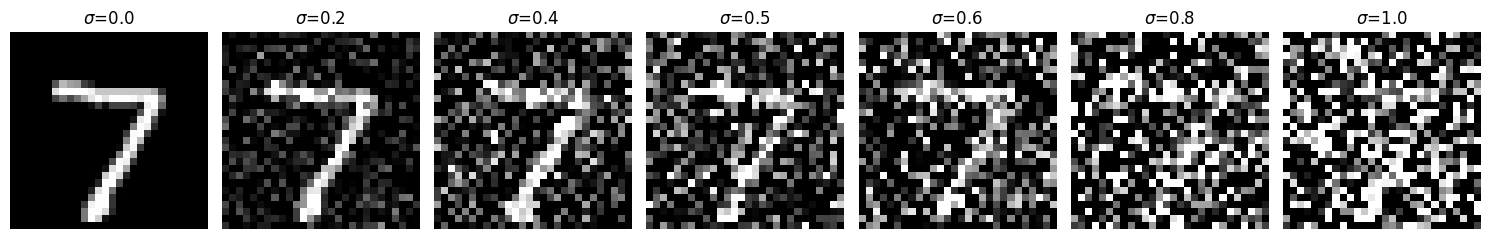

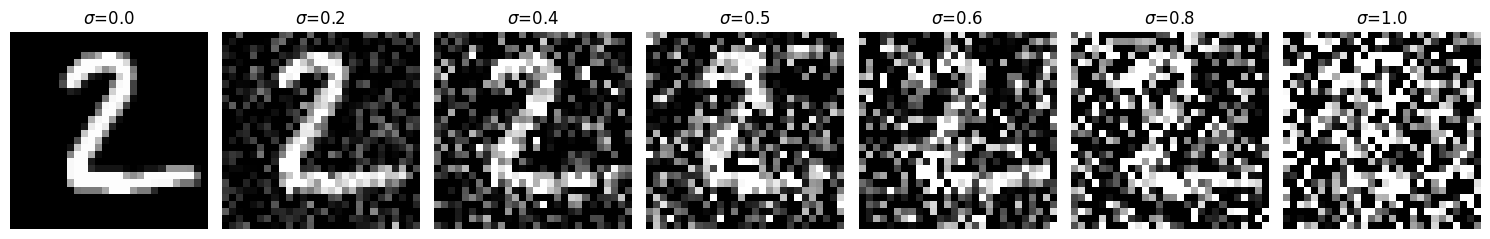

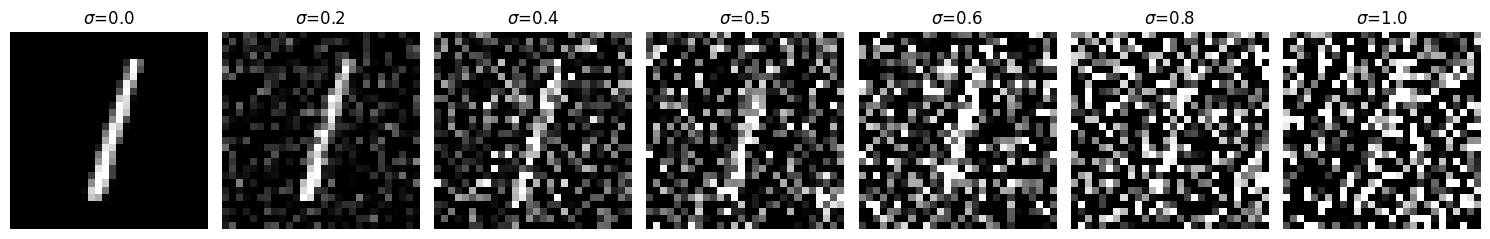

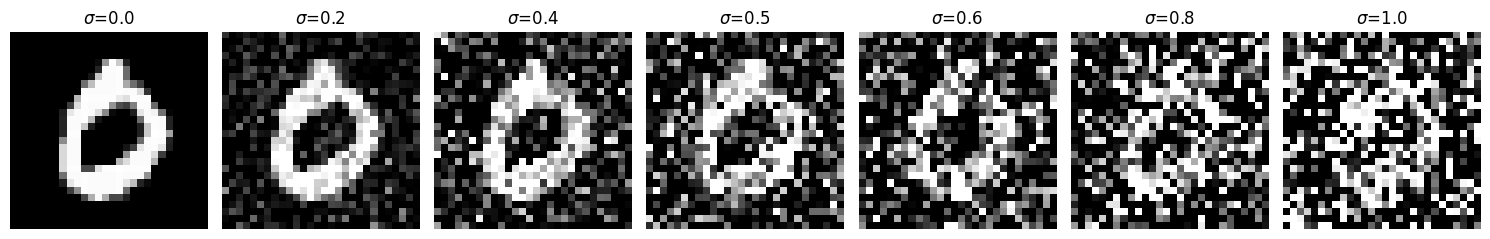

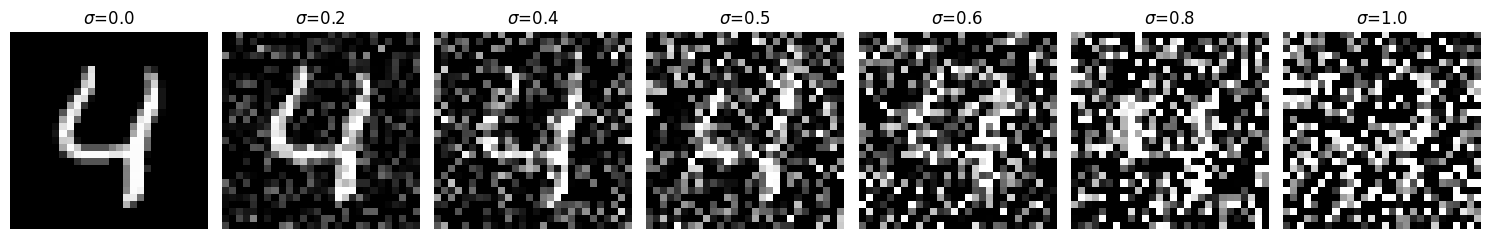

In [16]:
test_dataset = MNIST(root='data', train=False, transform=ToTensor(), download=True)

for indx in range(5):
    sample_image, _ = test_dataset[indx]
    sample_image = sample_image.unsqueeze(0)

    sigmas = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

    def add_noise(x, sigma):
        noise = torch.randn_like(x) * sigma
        return x + noise

    fig, axes = plt.subplots(1, len(sigmas), figsize=(15, 3))
    for idx, sigma in enumerate(sigmas):
        noisy_image = add_noise(sample_image, sigma)
        noisy_image = torch.clamp(noisy_image, 0.0, 1.0)
        axes[idx].imshow(noisy_image.squeeze(), cmap='gray')
        axes[idx].set_title(f'$\sigma$={sigma}')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

In [10]:
train_dataset = MNIST(root='data', train=True, transform=ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

model = UnconditionalUNet(in_channels=1, num_hiddens=128).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


num_epochs = 5
losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        sigma = 0.5
        noisy_x = x + torch.randn_like(x) * sigma
        optimizer.zero_grad()
        output = model(noisy_x)
        loss = criterion(output, x)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        losses.append(loss.item())
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    if epoch == 0:
        torch.save(model.state_dict(), 'unet_epoch_1.pth')
    if epoch == 4:
        torch.save(model.state_dict(), 'unet_epoch_5.pth')

Epoch [1/5], Batch [1/235], Loss: 0.3559
Epoch [1/5], Batch [2/235], Loss: 0.3024
Epoch [1/5], Batch [3/235], Loss: 0.1689
Epoch [1/5], Batch [4/235], Loss: 0.1365
Epoch [1/5], Batch [5/235], Loss: 0.1152
Epoch [1/5], Batch [6/235], Loss: 0.1000
Epoch [1/5], Batch [7/235], Loss: 0.0934
Epoch [1/5], Batch [8/235], Loss: 0.0858
Epoch [1/5], Batch [9/235], Loss: 0.0769
Epoch [1/5], Batch [10/235], Loss: 0.0693
Epoch [1/5], Batch [11/235], Loss: 0.0653
Epoch [1/5], Batch [12/235], Loss: 0.0633
Epoch [1/5], Batch [13/235], Loss: 0.0607
Epoch [1/5], Batch [14/235], Loss: 0.0580
Epoch [1/5], Batch [15/235], Loss: 0.0537
Epoch [1/5], Batch [16/235], Loss: 0.0501
Epoch [1/5], Batch [17/235], Loss: 0.0476
Epoch [1/5], Batch [18/235], Loss: 0.0466
Epoch [1/5], Batch [19/235], Loss: 0.0451
Epoch [1/5], Batch [20/235], Loss: 0.0433
Epoch [1/5], Batch [21/235], Loss: 0.0419
Epoch [1/5], Batch [22/235], Loss: 0.0405
Epoch [1/5], Batch [23/235], Loss: 0.0390
Epoch [1/5], Batch [24/235], Loss: 0.0390
E

Epoch [1/5], Batch [195/235], Loss: 0.0140
Epoch [1/5], Batch [196/235], Loss: 0.0140
Epoch [1/5], Batch [197/235], Loss: 0.0140
Epoch [1/5], Batch [198/235], Loss: 0.0137
Epoch [1/5], Batch [199/235], Loss: 0.0141
Epoch [1/5], Batch [200/235], Loss: 0.0136
Epoch [1/5], Batch [201/235], Loss: 0.0140
Epoch [1/5], Batch [202/235], Loss: 0.0138
Epoch [1/5], Batch [203/235], Loss: 0.0143
Epoch [1/5], Batch [204/235], Loss: 0.0144
Epoch [1/5], Batch [205/235], Loss: 0.0136
Epoch [1/5], Batch [206/235], Loss: 0.0136
Epoch [1/5], Batch [207/235], Loss: 0.0138
Epoch [1/5], Batch [208/235], Loss: 0.0137
Epoch [1/5], Batch [209/235], Loss: 0.0135
Epoch [1/5], Batch [210/235], Loss: 0.0137
Epoch [1/5], Batch [211/235], Loss: 0.0139
Epoch [1/5], Batch [212/235], Loss: 0.0138
Epoch [1/5], Batch [213/235], Loss: 0.0136
Epoch [1/5], Batch [214/235], Loss: 0.0142
Epoch [1/5], Batch [215/235], Loss: 0.0135
Epoch [1/5], Batch [216/235], Loss: 0.0133
Epoch [1/5], Batch [217/235], Loss: 0.0141
Epoch [1/5]

Epoch [2/5], Batch [154/235], Loss: 0.0118
Epoch [2/5], Batch [155/235], Loss: 0.0118
Epoch [2/5], Batch [156/235], Loss: 0.0117
Epoch [2/5], Batch [157/235], Loss: 0.0112
Epoch [2/5], Batch [158/235], Loss: 0.0115
Epoch [2/5], Batch [159/235], Loss: 0.0116
Epoch [2/5], Batch [160/235], Loss: 0.0120
Epoch [2/5], Batch [161/235], Loss: 0.0117
Epoch [2/5], Batch [162/235], Loss: 0.0112
Epoch [2/5], Batch [163/235], Loss: 0.0115
Epoch [2/5], Batch [164/235], Loss: 0.0116
Epoch [2/5], Batch [165/235], Loss: 0.0114
Epoch [2/5], Batch [166/235], Loss: 0.0115
Epoch [2/5], Batch [167/235], Loss: 0.0108
Epoch [2/5], Batch [168/235], Loss: 0.0119
Epoch [2/5], Batch [169/235], Loss: 0.0117
Epoch [2/5], Batch [170/235], Loss: 0.0111
Epoch [2/5], Batch [171/235], Loss: 0.0113
Epoch [2/5], Batch [172/235], Loss: 0.0114
Epoch [2/5], Batch [173/235], Loss: 0.0114
Epoch [2/5], Batch [174/235], Loss: 0.0115
Epoch [2/5], Batch [175/235], Loss: 0.0123
Epoch [2/5], Batch [176/235], Loss: 0.0113
Epoch [2/5]

Epoch [3/5], Batch [113/235], Loss: 0.0103
Epoch [3/5], Batch [114/235], Loss: 0.0102
Epoch [3/5], Batch [115/235], Loss: 0.0104
Epoch [3/5], Batch [116/235], Loss: 0.0102
Epoch [3/5], Batch [117/235], Loss: 0.0104
Epoch [3/5], Batch [118/235], Loss: 0.0107
Epoch [3/5], Batch [119/235], Loss: 0.0102
Epoch [3/5], Batch [120/235], Loss: 0.0102
Epoch [3/5], Batch [121/235], Loss: 0.0103
Epoch [3/5], Batch [122/235], Loss: 0.0102
Epoch [3/5], Batch [123/235], Loss: 0.0098
Epoch [3/5], Batch [124/235], Loss: 0.0106
Epoch [3/5], Batch [125/235], Loss: 0.0106
Epoch [3/5], Batch [126/235], Loss: 0.0101
Epoch [3/5], Batch [127/235], Loss: 0.0103
Epoch [3/5], Batch [128/235], Loss: 0.0100
Epoch [3/5], Batch [129/235], Loss: 0.0102
Epoch [3/5], Batch [130/235], Loss: 0.0103
Epoch [3/5], Batch [131/235], Loss: 0.0108
Epoch [3/5], Batch [132/235], Loss: 0.0103
Epoch [3/5], Batch [133/235], Loss: 0.0103
Epoch [3/5], Batch [134/235], Loss: 0.0104
Epoch [3/5], Batch [135/235], Loss: 0.0101
Epoch [3/5]

Epoch [4/5], Batch [71/235], Loss: 0.0096
Epoch [4/5], Batch [72/235], Loss: 0.0096
Epoch [4/5], Batch [73/235], Loss: 0.0098
Epoch [4/5], Batch [74/235], Loss: 0.0094
Epoch [4/5], Batch [75/235], Loss: 0.0092
Epoch [4/5], Batch [76/235], Loss: 0.0095
Epoch [4/5], Batch [77/235], Loss: 0.0095
Epoch [4/5], Batch [78/235], Loss: 0.0097
Epoch [4/5], Batch [79/235], Loss: 0.0096
Epoch [4/5], Batch [80/235], Loss: 0.0101
Epoch [4/5], Batch [81/235], Loss: 0.0098
Epoch [4/5], Batch [82/235], Loss: 0.0100
Epoch [4/5], Batch [83/235], Loss: 0.0097
Epoch [4/5], Batch [84/235], Loss: 0.0094
Epoch [4/5], Batch [85/235], Loss: 0.0097
Epoch [4/5], Batch [86/235], Loss: 0.0092
Epoch [4/5], Batch [87/235], Loss: 0.0096
Epoch [4/5], Batch [88/235], Loss: 0.0095
Epoch [4/5], Batch [89/235], Loss: 0.0097
Epoch [4/5], Batch [90/235], Loss: 0.0094
Epoch [4/5], Batch [91/235], Loss: 0.0098
Epoch [4/5], Batch [92/235], Loss: 0.0097
Epoch [4/5], Batch [93/235], Loss: 0.0098
Epoch [4/5], Batch [94/235], Loss:

Epoch [5/5], Batch [29/235], Loss: 0.0095
Epoch [5/5], Batch [30/235], Loss: 0.0091
Epoch [5/5], Batch [31/235], Loss: 0.0094
Epoch [5/5], Batch [32/235], Loss: 0.0092
Epoch [5/5], Batch [33/235], Loss: 0.0096
Epoch [5/5], Batch [34/235], Loss: 0.0093
Epoch [5/5], Batch [35/235], Loss: 0.0091
Epoch [5/5], Batch [36/235], Loss: 0.0097
Epoch [5/5], Batch [37/235], Loss: 0.0091
Epoch [5/5], Batch [38/235], Loss: 0.0092
Epoch [5/5], Batch [39/235], Loss: 0.0093
Epoch [5/5], Batch [40/235], Loss: 0.0092
Epoch [5/5], Batch [41/235], Loss: 0.0094
Epoch [5/5], Batch [42/235], Loss: 0.0086
Epoch [5/5], Batch [43/235], Loss: 0.0093
Epoch [5/5], Batch [44/235], Loss: 0.0092
Epoch [5/5], Batch [45/235], Loss: 0.0091
Epoch [5/5], Batch [46/235], Loss: 0.0091
Epoch [5/5], Batch [47/235], Loss: 0.0092
Epoch [5/5], Batch [48/235], Loss: 0.0091
Epoch [5/5], Batch [49/235], Loss: 0.0089
Epoch [5/5], Batch [50/235], Loss: 0.0090
Epoch [5/5], Batch [51/235], Loss: 0.0092
Epoch [5/5], Batch [52/235], Loss:

Epoch [5/5], Batch [222/235], Loss: 0.0087
Epoch [5/5], Batch [223/235], Loss: 0.0087
Epoch [5/5], Batch [224/235], Loss: 0.0088
Epoch [5/5], Batch [225/235], Loss: 0.0087
Epoch [5/5], Batch [226/235], Loss: 0.0089
Epoch [5/5], Batch [227/235], Loss: 0.0085
Epoch [5/5], Batch [228/235], Loss: 0.0093
Epoch [5/5], Batch [229/235], Loss: 0.0088
Epoch [5/5], Batch [230/235], Loss: 0.0088
Epoch [5/5], Batch [231/235], Loss: 0.0088
Epoch [5/5], Batch [232/235], Loss: 0.0089
Epoch [5/5], Batch [233/235], Loss: 0.0087
Epoch [5/5], Batch [234/235], Loss: 0.0091
Epoch [5/5], Batch [235/235], Loss: 0.0088


### Deliverable 2
### A training loss curve plot every few iterations during the whole training process

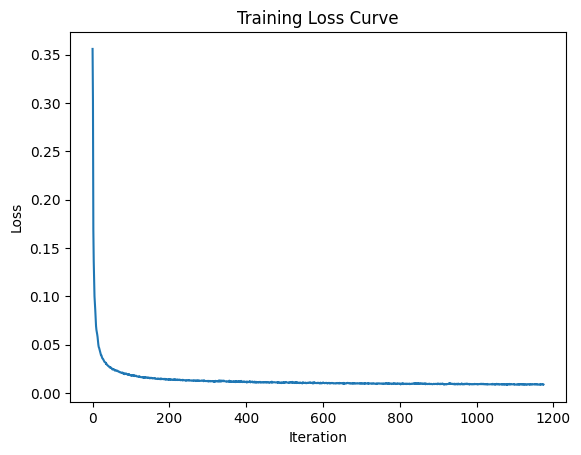

In [11]:
plt.figure()
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

### Deliverable 3
### Sample results on the test set after the first and the 5-th epoch (staff solution takes ~7 minutes for 5 epochs on a Colab T4 GPU)

/tmp/ipykernel_3413798/3879046741.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_epoch1.load_state_dict(torch.load('unet_epoch_1.pth', map_location=device))


Denoising results after 1 epoch:


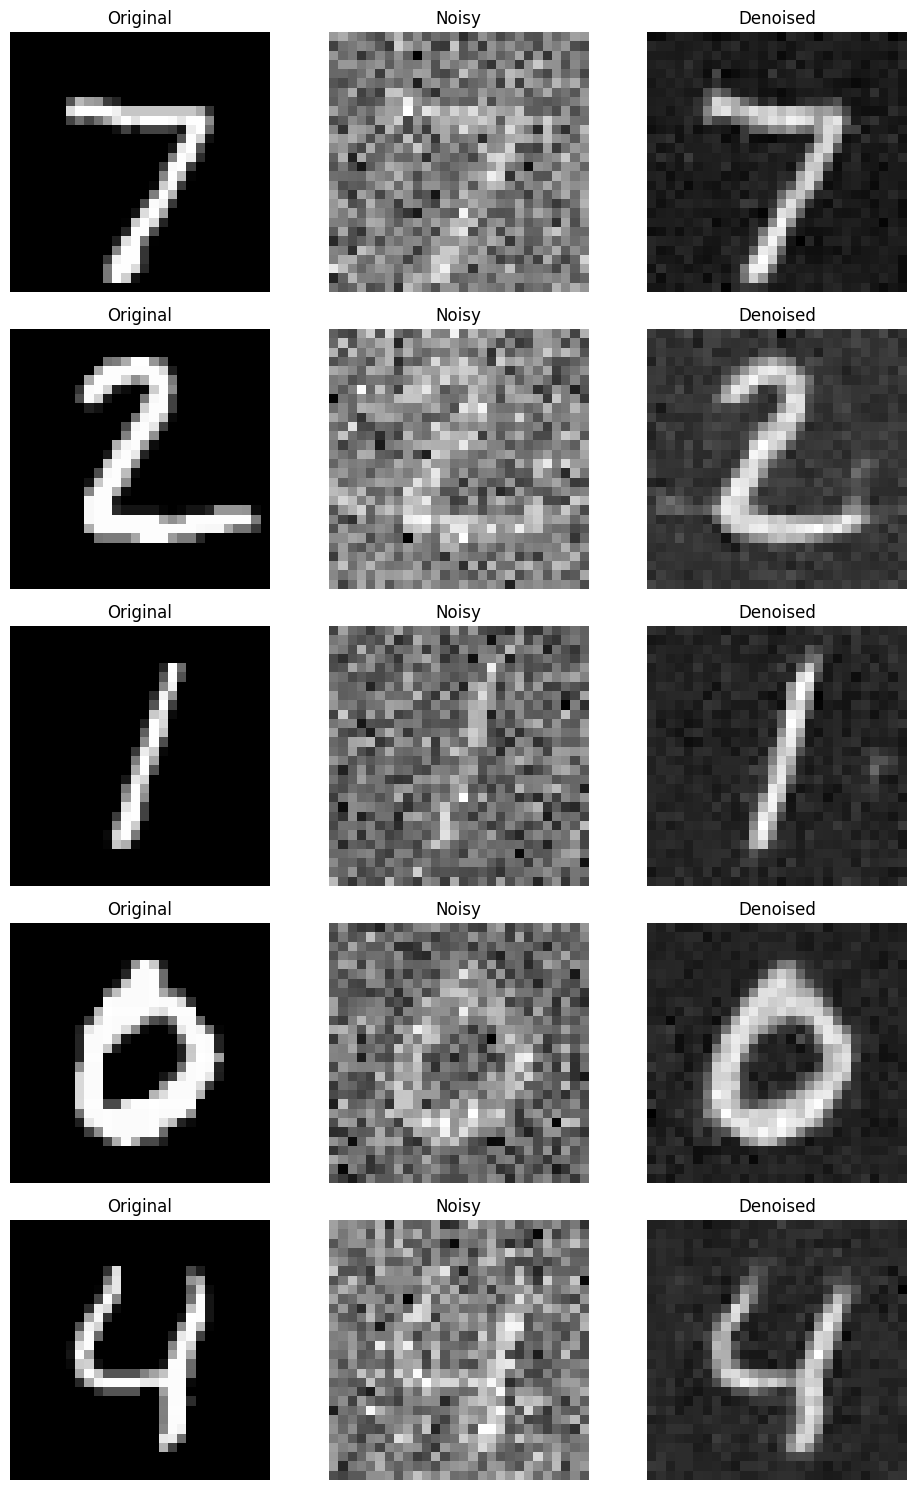

/tmp/ipykernel_3413798/3879046741.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_epoch5.load_state_dict(torch.load('unet_epoch_5.pth', map_location=device))


Denoising results after 5 epochs:


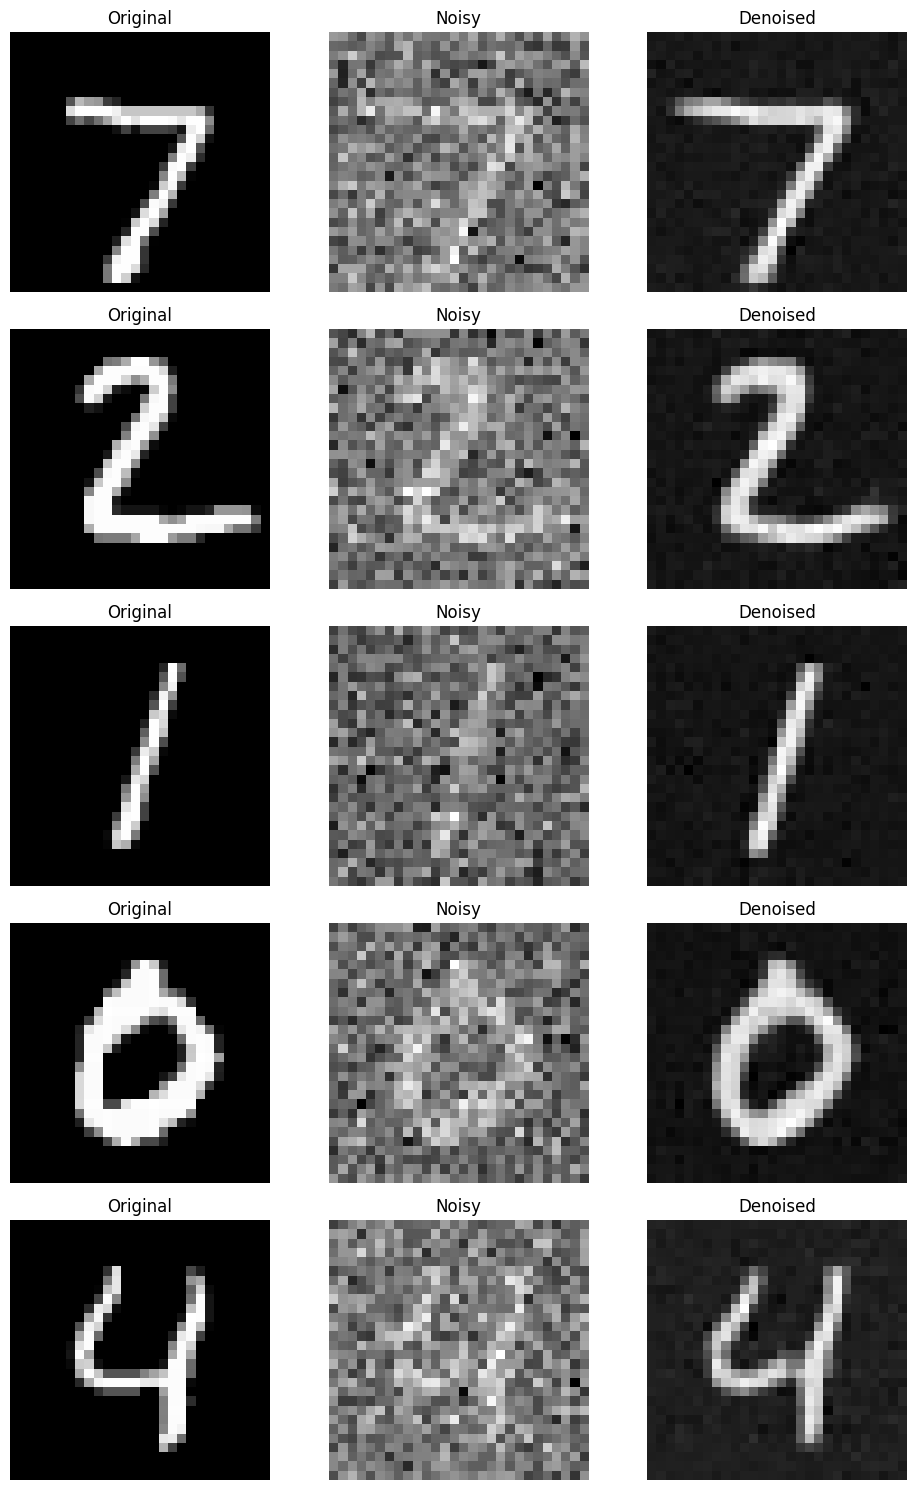

In [14]:
def denoise_and_plot(model, data_loader, sigma=0.5, num_images=5):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(data_loader))
        x = x.to(device)
        noisy_x = x + torch.randn_like(x) * sigma
        output = model(noisy_x)
        
        fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 3))
        for i in range(num_images):
            axes[i, 0].imshow(x[i].cpu().squeeze(), cmap='gray')
            axes[i, 0].set_title('Original')
            axes[i, 1].imshow(noisy_x[i].cpu().squeeze(), cmap='gray')
            axes[i, 1].set_title('Noisy')
            axes[i, 2].imshow(output[i].cpu().squeeze(), cmap='gray')
            axes[i, 2].set_title('Denoised')
            for ax in axes[i]:
                ax.axis('off')
        plt.tight_layout()
        plt.show()
        
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model_epoch1 = UnconditionalUNet(in_channels=1, num_hiddens=128).to(device)
model_epoch1.load_state_dict(torch.load('unet_epoch_1.pth', map_location=device))

print("Denoising results after 1 epoch:")
denoise_and_plot(model_epoch1, test_loader, sigma=0.5, num_images=5)

model_epoch5 = UnconditionalUNet(in_channels=1, num_hiddens=128).to(device)
model_epoch5.load_state_dict(torch.load('unet_epoch_5.pth', map_location=device))

print("Denoising results after 5 epochs:")
denoise_and_plot(model_epoch5, test_loader, sigma=0.5, num_images=5)

### Deliverable 4
### Sample results on the test set with out-of-distribution noise levels after the model is trained. Keep the same image and vary $\sigma=[0.0,0.2,0.4,0.5,0.6,0.8,1.0]$.

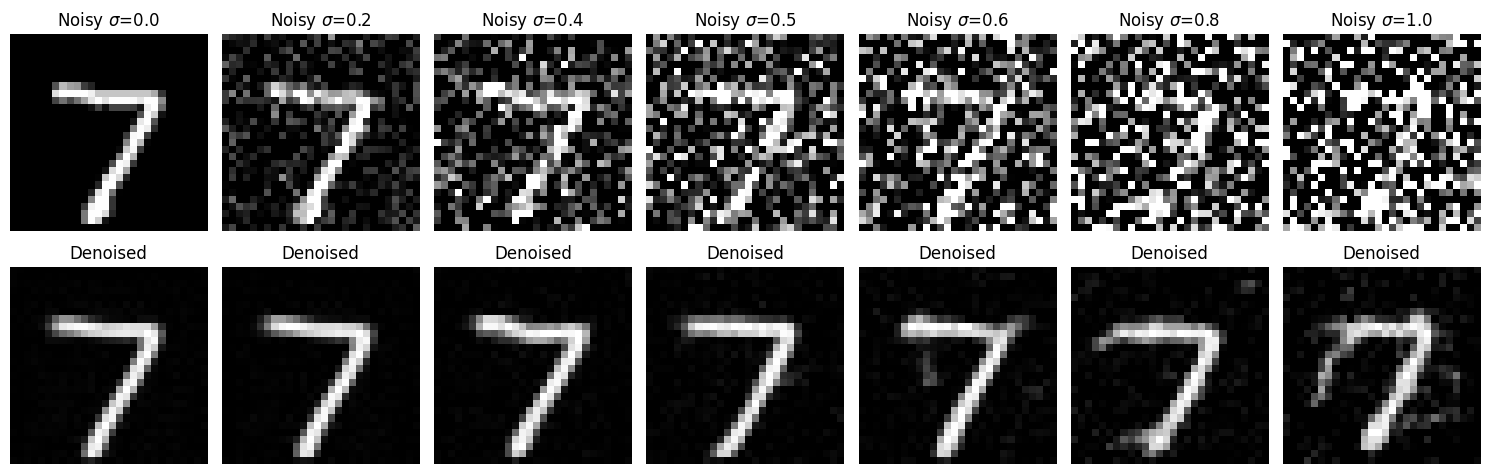

In [15]:
sigmas = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

sample_image, _ = test_dataset[0]
sample_image = sample_image.unsqueeze(0).to(device)

model_epoch5.eval()
with torch.no_grad():
    fig, axes = plt.subplots(2, len(sigmas), figsize=(15, 5))
    for idx, sigma in enumerate(sigmas):
        noisy_image = sample_image + torch.randn_like(sample_image) * sigma
        denoised_image = model_epoch5(noisy_image)
        
        noisy_image = torch.clamp(noisy_image, 0.0, 1.0)
        denoised_image = torch.clamp(denoised_image, 0.0, 1.0)
        
        axes[0, idx].imshow(noisy_image.cpu().squeeze(), cmap='gray')
        axes[0, idx].set_title(f'Noisy $\sigma$={sigma}')
        axes[0, idx].axis('off')
        
        axes[1, idx].imshow(denoised_image.cpu().squeeze(), cmap='gray')
        axes[1, idx].set_title('Denoised')
        axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

# Part 2: Training a Diffusion Model

## Implementing a Time-conditioned UNet

In [63]:
class FCBlock(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc(x)

In [64]:
class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.conv_in = Conv(in_channels, num_hiddens)
        self.down1 = DownBlock(num_hiddens, num_hiddens * 2)
        self.down2 = DownBlock(num_hiddens * 2, num_hiddens * 4)
        self.flatten = Flatten()

        self.fc1_t = FCBlock(1, num_hiddens * 4)
        self.fc2_t = FCBlock(1, num_hiddens * 2)

        self.unflatten = Unflatten(num_hiddens * 4, num_hiddens * 4)
        self.up1 = UpBlock(num_hiddens * 8, num_hiddens * 2)
        self.up2 = UpBlock(num_hiddens * 4, num_hiddens)
        self.conv_out = nn.Conv2d(num_hiddens * 2, in_channels, kernel_size=1)

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        t = t.view(-1, 1)

        x1 = self.conv_in(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.flatten(x3)
        t1 = self.fc1_t(t)
        t1 = t1.view(-1, t1.size(1), 1, 1)
        x4 = x4 + t1
        x4 = self.unflatten(x4)
        x4 = torch.cat([x4, x3], dim=1)
        x5 = self.up1(x4)
        t2 = self.fc2_t(t)
        t2 = t2.view(-1, t2.size(1), 1, 1)
        x5 = x5 + t2
        x5 = torch.cat([x5, x2], dim=1)
        x6 = self.up2(x5)
        x6 = torch.cat([x6, x1], dim=1)
        out = self.conv_out(x6)
        return out

## Implementing DDPM Forward and Inverse Process for Time-conditioned Denoising

In [65]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."
    betas = torch.linspace(beta1, beta2, num_ts)
    alphas = 1.0 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    return {
        'betas': betas,
        'alphas': alphas,
        'alpha_bars': alpha_bars
    }

In [66]:
def ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    unet.train()

    N = x_0.size(0)
    device = x_0.device

    t = torch.randint(0, num_ts, (N,), device=device).long()

    alpha_bars = ddpm_schedule['alpha_bars'].to(device)
    sqrt_alpha_bars = torch.sqrt(alpha_bars)
    sqrt_one_minus_alpha_bars = torch.sqrt(1 - alpha_bars)

    sqrt_alpha_bar_t = sqrt_alpha_bars[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bars[t].view(-1, 1, 1, 1)

    epsilon = torch.randn_like(x_0)
    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * epsilon
    t_normalized = t / num_ts
    predicted_epsilon = unet(x_t, t_normalized)
    loss = nn.MSELoss()(predicted_epsilon, epsilon)
    return loss

In [67]:
@torch.no_grad()
def ddpm_sample(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    unet.eval()
    torch.manual_seed(seed)
    device = next(unet.parameters()).device
    N = 1
    C = 1
    H, W = img_wh
    x_t = torch.randn(N, C, H, W, device=device)
    betas = ddpm_schedule['betas'].to(device)
    alphas = ddpm_schedule['alphas'].to(device)
    alpha_bars = ddpm_schedule['alpha_bars'].to(device)
    sqrt_one_minus_alpha_bars = torch.sqrt(1 - alpha_bars)

    for t in reversed(range(num_ts)):
        t_batch = torch.full((N,), t, device=device, dtype=torch.long)
        t_normalized = t_batch / num_ts
        predicted_epsilon = unet(x_t, t_normalized)
        beta_t = betas[t]
        sqrt_alpha_t = torch.sqrt(alphas[t])
        sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bars[t]
        if t > 0:
            noise = torch.randn_like(x_t)
        else:
            noise = torch.zeros_like(x_t)
        coef1 = 1 / sqrt_alpha_t
        coef2 = beta_t / sqrt_one_minus_alpha_bar_t
        x_t = coef1 * (x_t - coef2 * predicted_epsilon) + noise * torch.sqrt(beta_t)
    return x_t

In [68]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
    ):
        super().__init__()
        self.unet = unet
        self.beta_range = betas
        self.num_ts = num_ts
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

        for k, v in self.ddpm_schedule.items():
            self.register_buffer(k, v)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, self.num_ts
        )

    @torch.no_grad()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, img_wh, self.num_ts, seed
        )

In [69]:
transform = ToTensor()
train_dataset = MNIST(root='data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

unet = TimeConditionalUNet(in_channels=1, num_hiddens=64).to(device)
ddpm_model = DDPM(unet=unet).to(device)

optimizer = optim.Adam(ddpm_model.parameters(), lr=1e-3)

num_epochs = 20
gamma = 0.1 ** (1 / num_epochs)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

losses = []

for epoch in range(num_epochs):
    ddpm_model.train()
    running_loss = 0.0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        loss = ddpm_model(x)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        losses.append(loss.item())
        if batch_idx % 100 == 0:
            avg_loss = running_loss / (batch_idx + 1)
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {avg_loss:.4f}")
    scheduler.step()
    
    if epoch == 4:
        torch.save(ddpm_model.state_dict(), 'ddpm_epoch_5.pth')
    if epoch == 19:
        torch.save(ddpm_model.state_dict(), 'ddpm_epoch_20.pth')

Epoch [1/20], Batch [1/469], Loss: 1.0947
Epoch [1/20], Batch [101/469], Loss: 0.1530
Epoch [1/20], Batch [201/469], Loss: 0.1123
Epoch [1/20], Batch [301/469], Loss: 0.0955
Epoch [1/20], Batch [401/469], Loss: 0.0856
Epoch [2/20], Batch [1/469], Loss: 0.0431
Epoch [2/20], Batch [101/469], Loss: 0.0489
Epoch [2/20], Batch [201/469], Loss: 0.0477
Epoch [2/20], Batch [301/469], Loss: 0.0477
Epoch [2/20], Batch [401/469], Loss: 0.0469
Epoch [3/20], Batch [1/469], Loss: 0.0417
Epoch [3/20], Batch [101/469], Loss: 0.0421
Epoch [3/20], Batch [201/469], Loss: 0.0412
Epoch [3/20], Batch [301/469], Loss: 0.0411
Epoch [3/20], Batch [401/469], Loss: 0.0408
Epoch [4/20], Batch [1/469], Loss: 0.0433
Epoch [4/20], Batch [101/469], Loss: 0.0391
Epoch [4/20], Batch [201/469], Loss: 0.0385
Epoch [4/20], Batch [301/469], Loss: 0.0382
Epoch [4/20], Batch [401/469], Loss: 0.0381
Epoch [5/20], Batch [1/469], Loss: 0.0364
Epoch [5/20], Batch [101/469], Loss: 0.0362
Epoch [5/20], Batch [201/469], Loss: 0.036

### Deliverable 1 -- P2
### A training loss curve plot for the time-conditioned UNet over the whole training process (figure 10).

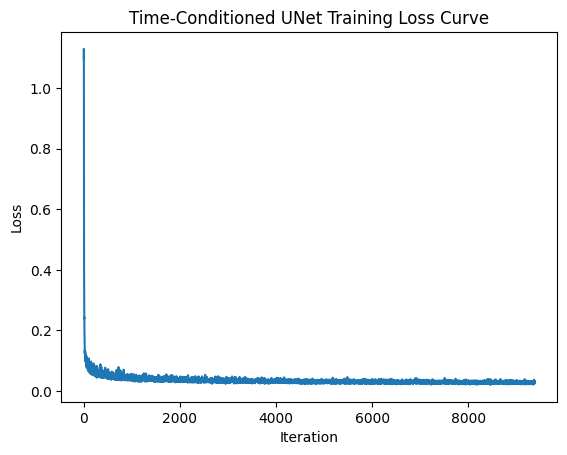

In [70]:
plt.figure()
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Time-Conditioned UNet Training Loss Curve')
plt.show()

### Deliverable 2 -- P2
### Sampling results for the time-conditioned UNet for 5 and 20 epochs.

/tmp/ipykernel_3413798/21440045.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ddpm_model_epoch5.load_state_dict(torch.load('ddpm_epoch_5.pth', map_location=device))
/t

Samples after 5 epochs:


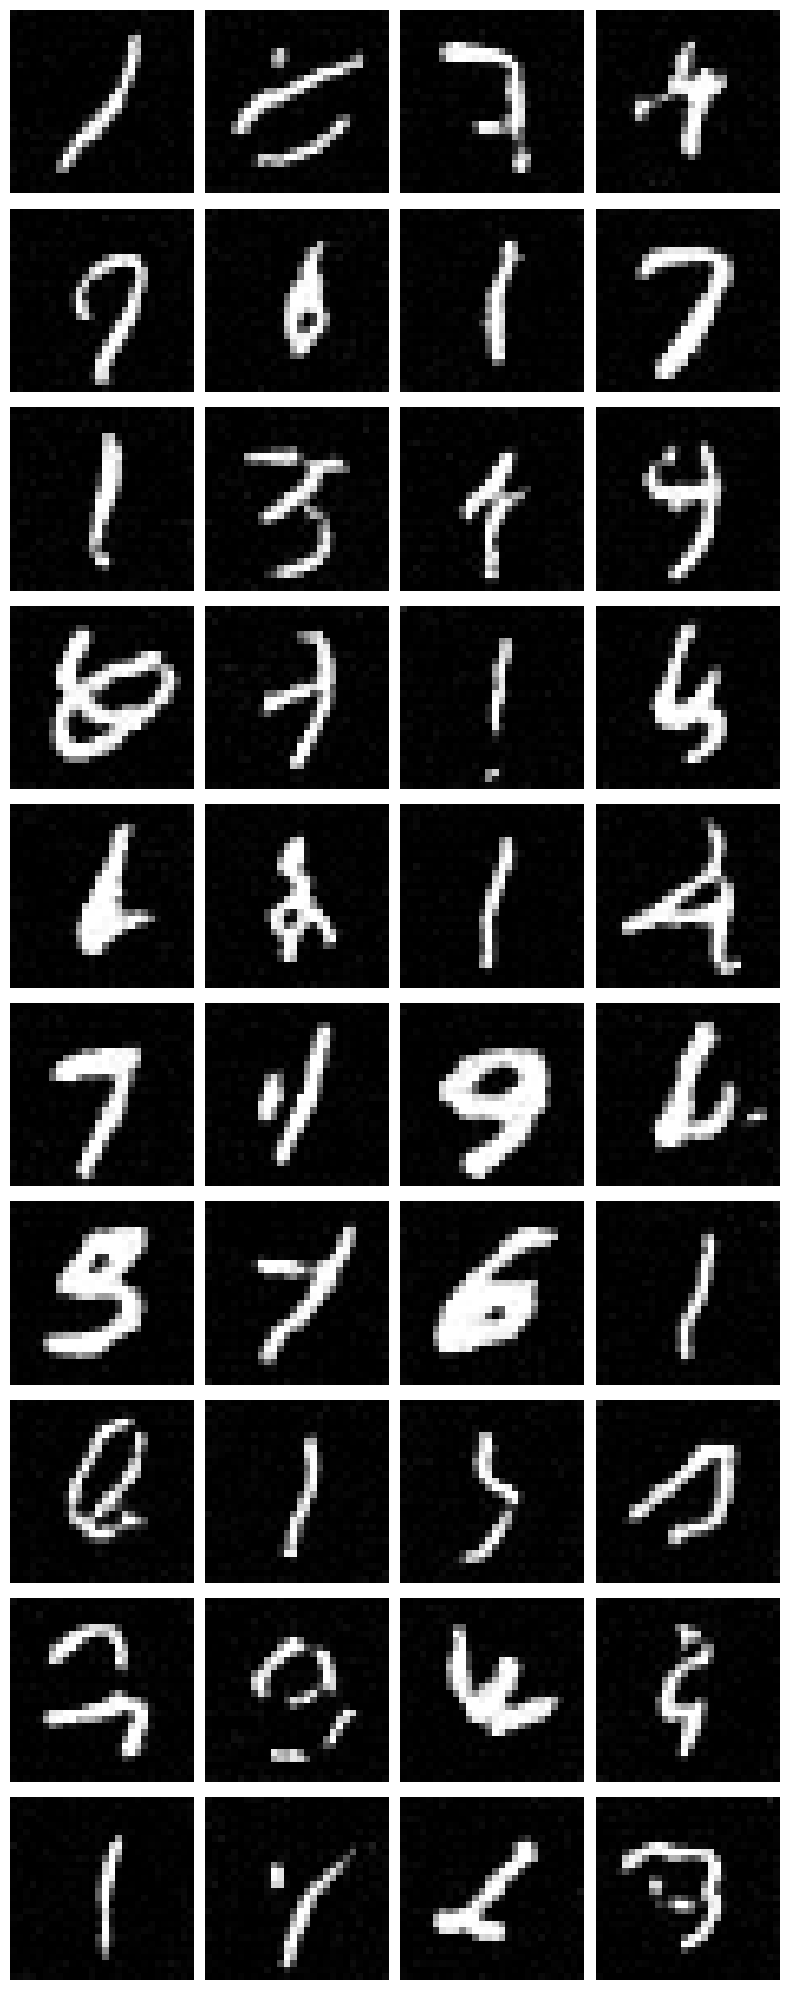

Samples after 20 epochs:


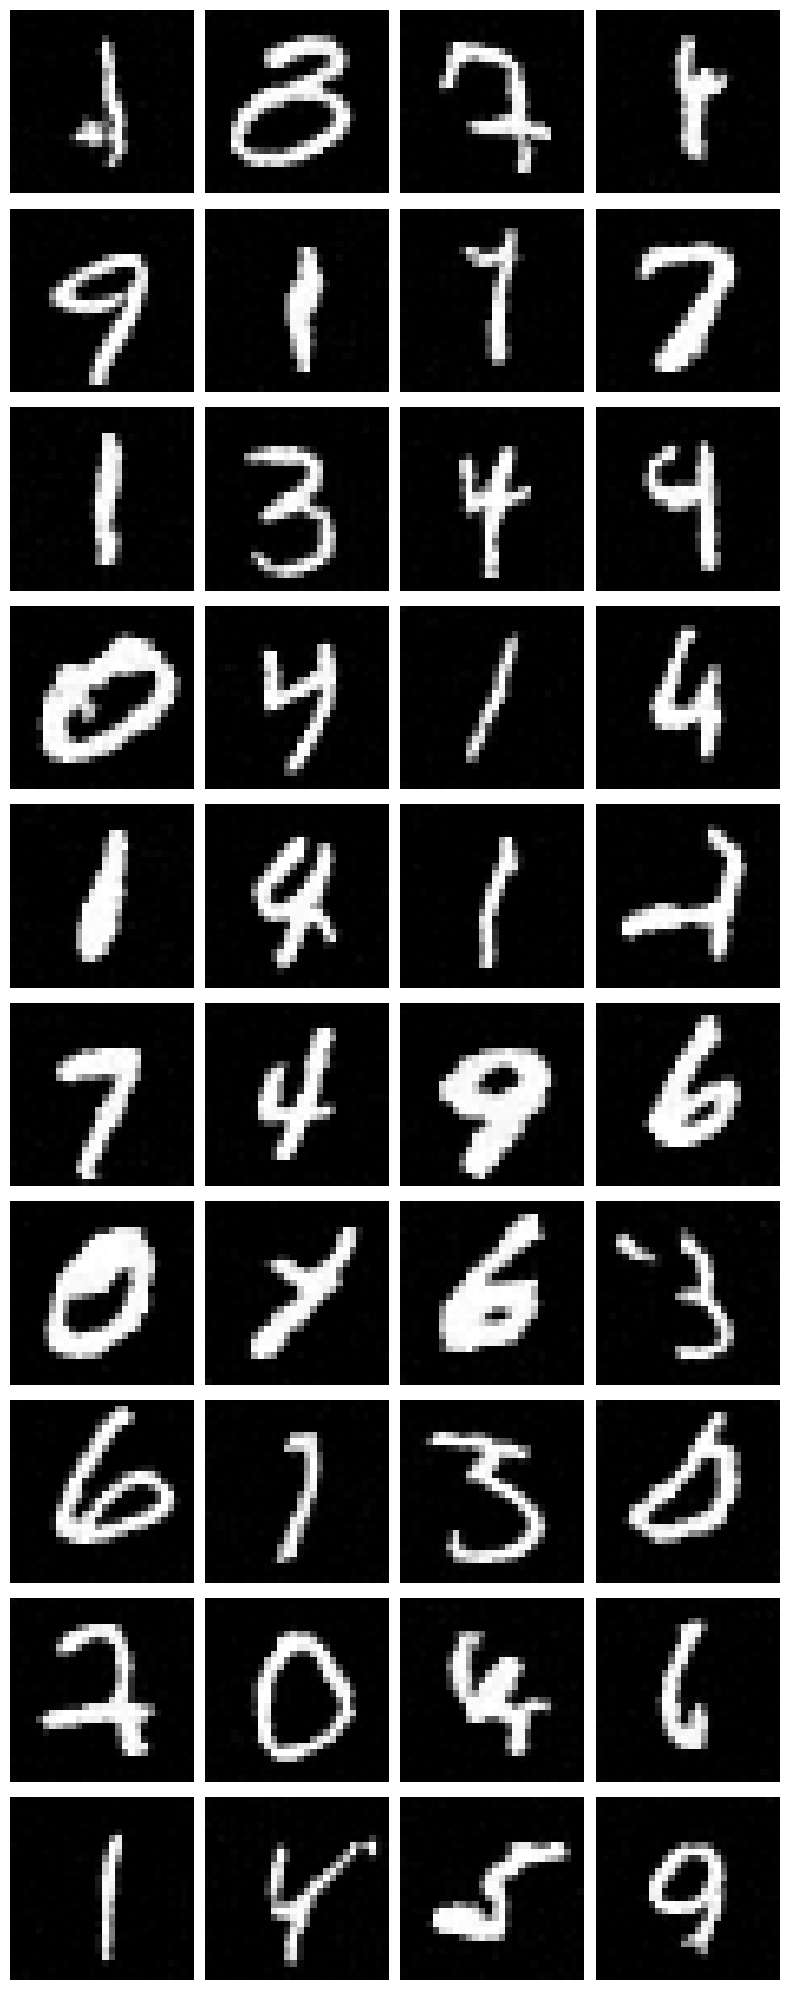

In [80]:
unet_epoch5 = TimeConditionalUNet(in_channels=1, num_hiddens=64).to(device)
ddpm_model_epoch5 = DDPM(unet=unet_epoch5).to(device)
ddpm_model_epoch5.load_state_dict(torch.load('ddpm_epoch_5.pth', map_location=device))

unet_epoch20 = TimeConditionalUNet(in_channels=1, num_hiddens=64).to(device)
ddpm_model_epoch20 = DDPM(unet=unet_epoch20).to(device)
ddpm_model_epoch20.load_state_dict(torch.load('ddpm_epoch_20.pth', map_location=device))

def generate_and_plot_samples_grid(ddpm_model, img_wh=(28,28), num_rows=10, num_cols=4, seed=0):
    ddpm_model.eval()
    samples = []
    for i in range(num_rows * num_cols):
        sample = ddpm_model.sample(img_wh=img_wh, seed=seed + i)
        samples.append(sample)
    samples = torch.cat(samples, dim=0)
    samples = samples.cpu().detach()
    samples = torch.clamp(samples, 0.0, 1.0)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    idx = 0
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i, j].imshow(samples[idx,0,:,:], cmap='gray')
            axes[i, j].axis('off')
            idx +=1
    plt.tight_layout()
    plt.show()

print("Samples after 5 epochs:")
generate_and_plot_samples_grid(ddpm_model_epoch5, num_rows=10, num_cols=4)

print("Samples after 20 epochs:")
generate_and_plot_samples_grid(ddpm_model_epoch20, num_rows=10, num_cols=4)

### Implementing class-conditioned UNet

In [72]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.conv_in = Conv(in_channels, num_hiddens)
        self.down1 = DownBlock(num_hiddens, num_hiddens * 2)
        self.down2 = DownBlock(num_hiddens * 2, num_hiddens * 4)
        self.flatten = Flatten()

        self.fc1_t = FCBlock(1, num_hiddens * 4)
        self.fc2_t = FCBlock(1, num_hiddens * 2)
        self.fc1_c = FCBlock(num_classes, num_hiddens * 4)
        self.fc2_c = FCBlock(num_classes, num_hiddens * 2)

        self.unflatten = Unflatten(num_hiddens * 4, num_hiddens * 4)
        self.up1 = UpBlock(num_hiddens * 8, num_hiddens * 2)
        self.up2 = UpBlock(num_hiddens * 4, num_hiddens)
        self.conv_out = nn.Conv2d(num_hiddens * 2, in_channels, kernel_size=1)

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        t = t.view(-1, 1)

        if mask is not None:
            c = c * mask.view(-1, 1)

        x1 = self.conv_in(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.flatten(x3)

        t1 = self.fc1_t(t)
        c1 = self.fc1_c(c)
        t1 = t1.view(-1, t1.size(1), 1, 1)
        c1 = c1.view(-1, c1.size(1), 1, 1)
        x4 = c1 * x4 + t1

        x4 = self.unflatten(x4)
        x4 = torch.cat([x4, x3], dim=1)
        x5 = self.up1(x4)

        t2 = self.fc2_t(t)
        c2 = self.fc2_c(c)
        t2 = t2.view(-1, t2.size(1), 1, 1)
        c2 = c2.view(-1, c2.size(1), 1, 1)
        x5 = c2 * x5 + t2

        x5 = torch.cat([x5, x2], dim=1)
        x6 = self.up2(x5)
        x6 = torch.cat([x6, x1], dim=1)
        out = self.conv_out(x6)
        return out

In [73]:
def ddpm_forward_class(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    unet.train()

    N = x_0.size(0)
    device = x_0.device

    t = torch.randint(0, num_ts, (N,), device=device).long()

    alpha_bars = ddpm_schedule['alpha_bars'].to(device)
    sqrt_alpha_bars = torch.sqrt(alpha_bars)
    sqrt_one_minus_alpha_bars = torch.sqrt(1 - alpha_bars)

    sqrt_alpha_bar_t = sqrt_alpha_bars[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bars[t].view(-1, 1, 1, 1)

    epsilon = torch.randn_like(x_0)

    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * epsilon

    t_normalized = t / num_ts

    num_classes = unet.fc1_c.fc[0].in_features
    c_one_hot = torch.nn.functional.one_hot(c, num_classes=num_classes).float().to(device)

    mask = torch.bernoulli(torch.ones(N, device=device) * (1 - p_uncond))
    c_masked = c_one_hot * mask.view(-1, 1)

    predicted_epsilon = unet(x_t, c_masked, t_normalized, mask)

    loss = nn.MSELoss()(predicted_epsilon, epsilon)

    return loss

In [74]:
@torch.no_grad()
def ddpm_sample_class(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    unet.eval()
    torch.manual_seed(seed)
    device = next(unet.parameters()).device

    N = c.size(0)
    C = 1
    H, W = img_wh

    x_t = torch.randn(N, C, H, W, device=device)

    betas = ddpm_schedule['betas'].to(device)
    alphas = ddpm_schedule['alphas'].to(device)
    alpha_bars = ddpm_schedule['alpha_bars'].to(device)
    sqrt_one_minus_alpha_bars = torch.sqrt(1 - alpha_bars)

    num_classes = unet.fc1_c.fc[0].in_features
    c_one_hot = torch.nn.functional.one_hot(c, num_classes=num_classes).float().to(device)

    c_uncond = torch.zeros_like(c_one_hot)

    for t in reversed(range(num_ts)):
        t_batch = torch.full((N,), t, device=device, dtype=torch.long)
        t_normalized = t_batch / num_ts

        predicted_epsilon_cond = unet(x_t, c_one_hot, t_normalized, mask=None)
        predicted_epsilon_uncond = unet(x_t, c_uncond, t_normalized, mask=None)

        predicted_epsilon = predicted_epsilon_uncond + guidance_scale * (predicted_epsilon_cond - predicted_epsilon_uncond)

        beta_t = betas[t]
        sqrt_alpha_t = torch.sqrt(alphas[t])
        sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bars[t]

        if t > 0:
            noise = torch.randn_like(x_t)
        else:
            noise = torch.zeros_like(x_t)

        coef1 = 1 / sqrt_alpha_t
        coef2 = beta_t / sqrt_one_minus_alpha_bar_t

        x_t = coef1 * (x_t - coef2 * predicted_epsilon) + noise * torch.sqrt(beta_t)
        
    return x_t

In [75]:
class DDPM_Class(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.beta_range = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

        for k, v in self.ddpm_schedule.items():
            self.register_buffer(k, v)

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        return ddpm_forward_class(
            self.unet, self.ddpm_schedule, x, c, self.p_uncond, self.num_ts
        )

    @torch.no_grad()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return ddpm_sample_class(
            self.unet, self.ddpm_schedule, c, img_wh, self.num_ts, guidance_scale, seed
        )

In [76]:
transform = ToTensor()
train_dataset = MNIST(root='data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

num_classes = 10
unet_class = ClassConditionalUNet(in_channels=1, num_classes=num_classes, num_hiddens=64).to(device)

ddpm_model_class = DDPM_Class(unet=unet_class, p_uncond=0.1).to(device)

optimizer = optim.Adam(ddpm_model_class.parameters(), lr=1e-3)

num_epochs = 20
gamma = 0.1 ** (1 / num_epochs)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

losses_class = []

for epoch in range(num_epochs):
    ddpm_model_class.train()
    running_loss = 0.0
    for batch_idx, (x, labels) in enumerate(train_loader):
        x = x.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        loss = ddpm_model_class(x, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        losses_class.append(loss.item())
        if batch_idx % 100 == 0:
            avg_loss = running_loss / (batch_idx + 1)
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {avg_loss:.4f}")
    scheduler.step()
    
    if epoch == 4:
        torch.save(ddpm_model_class.state_dict(), 'ddpm_class_epoch_5.pth')
    if epoch == 19:
        torch.save(ddpm_model_class.state_dict(), 'ddpm_class_epoch_20.pth')

Epoch [1/20], Batch [1/469], Loss: 1.1586
Epoch [1/20], Batch [101/469], Loss: 0.1569
Epoch [1/20], Batch [201/469], Loss: 0.1140
Epoch [1/20], Batch [301/469], Loss: 0.0952
Epoch [1/20], Batch [401/469], Loss: 0.0852
Epoch [2/20], Batch [1/469], Loss: 0.0557
Epoch [2/20], Batch [101/469], Loss: 0.0471
Epoch [2/20], Batch [201/469], Loss: 0.0458
Epoch [2/20], Batch [301/469], Loss: 0.0451
Epoch [2/20], Batch [401/469], Loss: 0.0443
Epoch [3/20], Batch [1/469], Loss: 0.0423
Epoch [3/20], Batch [101/469], Loss: 0.0402
Epoch [3/20], Batch [201/469], Loss: 0.0401
Epoch [3/20], Batch [301/469], Loss: 0.0398
Epoch [3/20], Batch [401/469], Loss: 0.0392
Epoch [4/20], Batch [1/469], Loss: 0.0380
Epoch [4/20], Batch [101/469], Loss: 0.0371
Epoch [4/20], Batch [201/469], Loss: 0.0368
Epoch [4/20], Batch [301/469], Loss: 0.0369
Epoch [4/20], Batch [401/469], Loss: 0.0366
Epoch [5/20], Batch [1/469], Loss: 0.0379
Epoch [5/20], Batch [101/469], Loss: 0.0350
Epoch [5/20], Batch [201/469], Loss: 0.034

### D1 
### A training loss curve plot for the class-conditioned UNet over the whole training process.

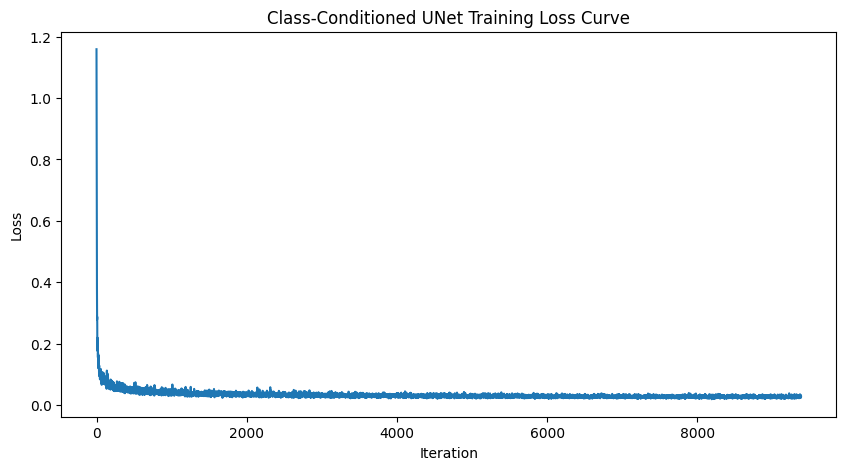

In [77]:
plt.figure(figsize=(10,5))
plt.plot(losses_class)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Class-Conditioned UNet Training Loss Curve')
plt.show()

### D2
### Sampling results for the class-conditioned UNet for 5 and 20 epochs. Generate 4 instances of each digit as shown above.

/tmp/ipykernel_3413798/2294403244.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ddpm_model_epoch5_class.load_state_dict(torch.load('ddpm_class_epoch_5.pth', map_locati

Class-Conditioned Samples after 5 epochs:


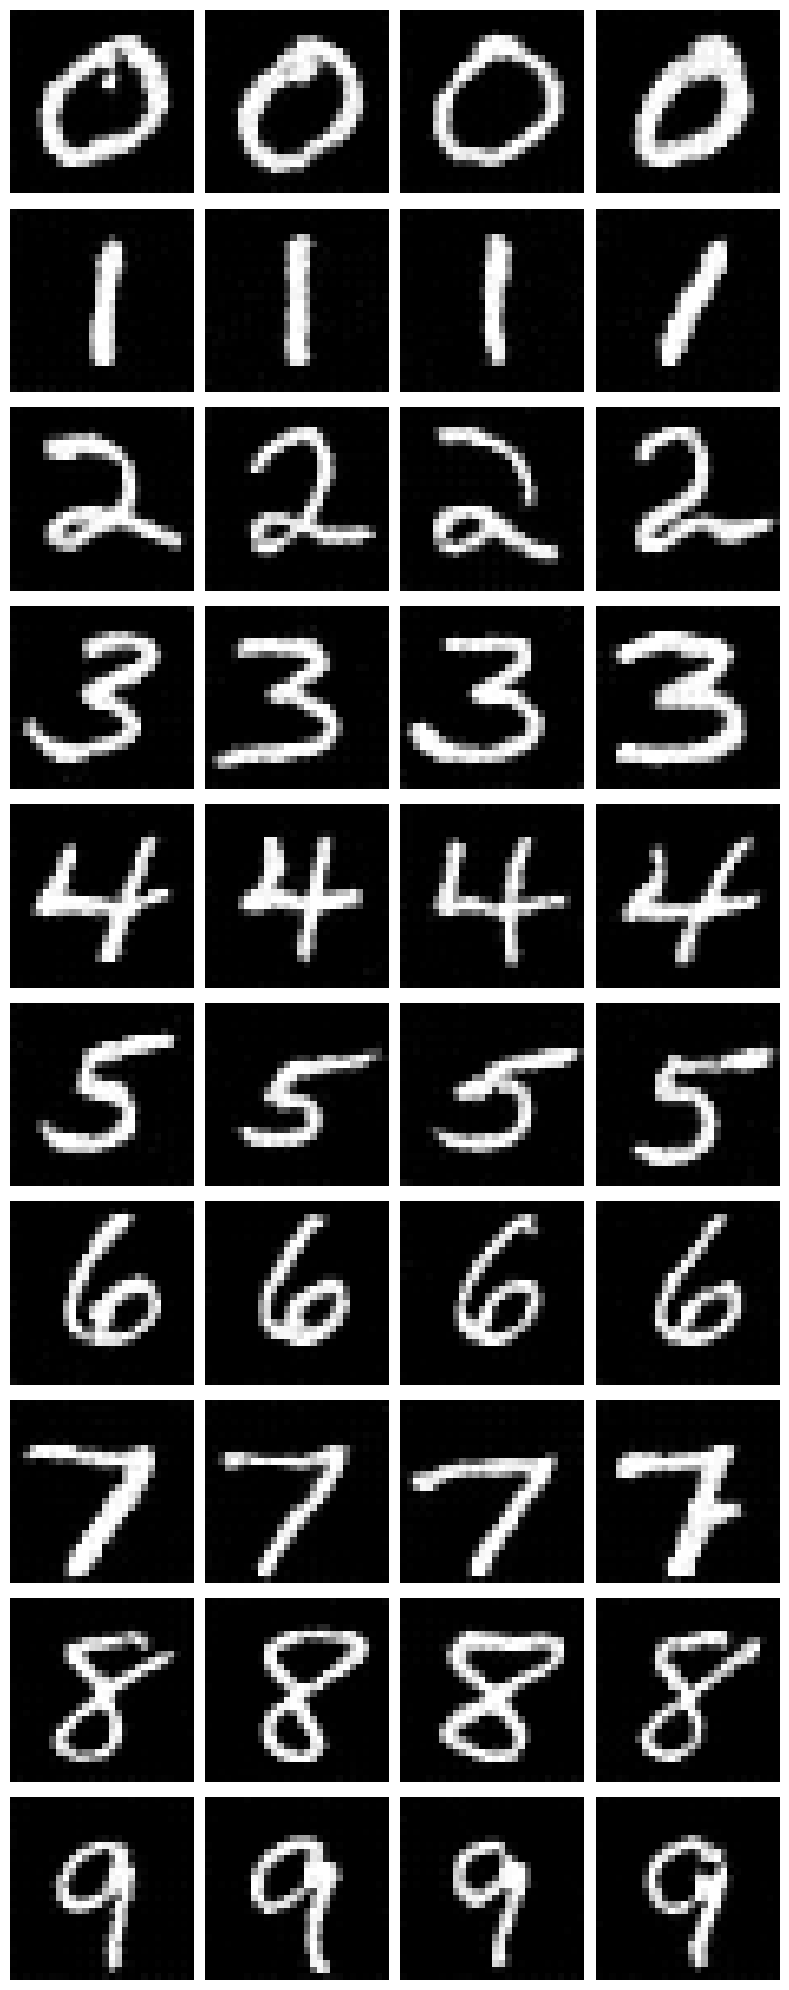

Class-Conditioned Samples after 20 epochs:


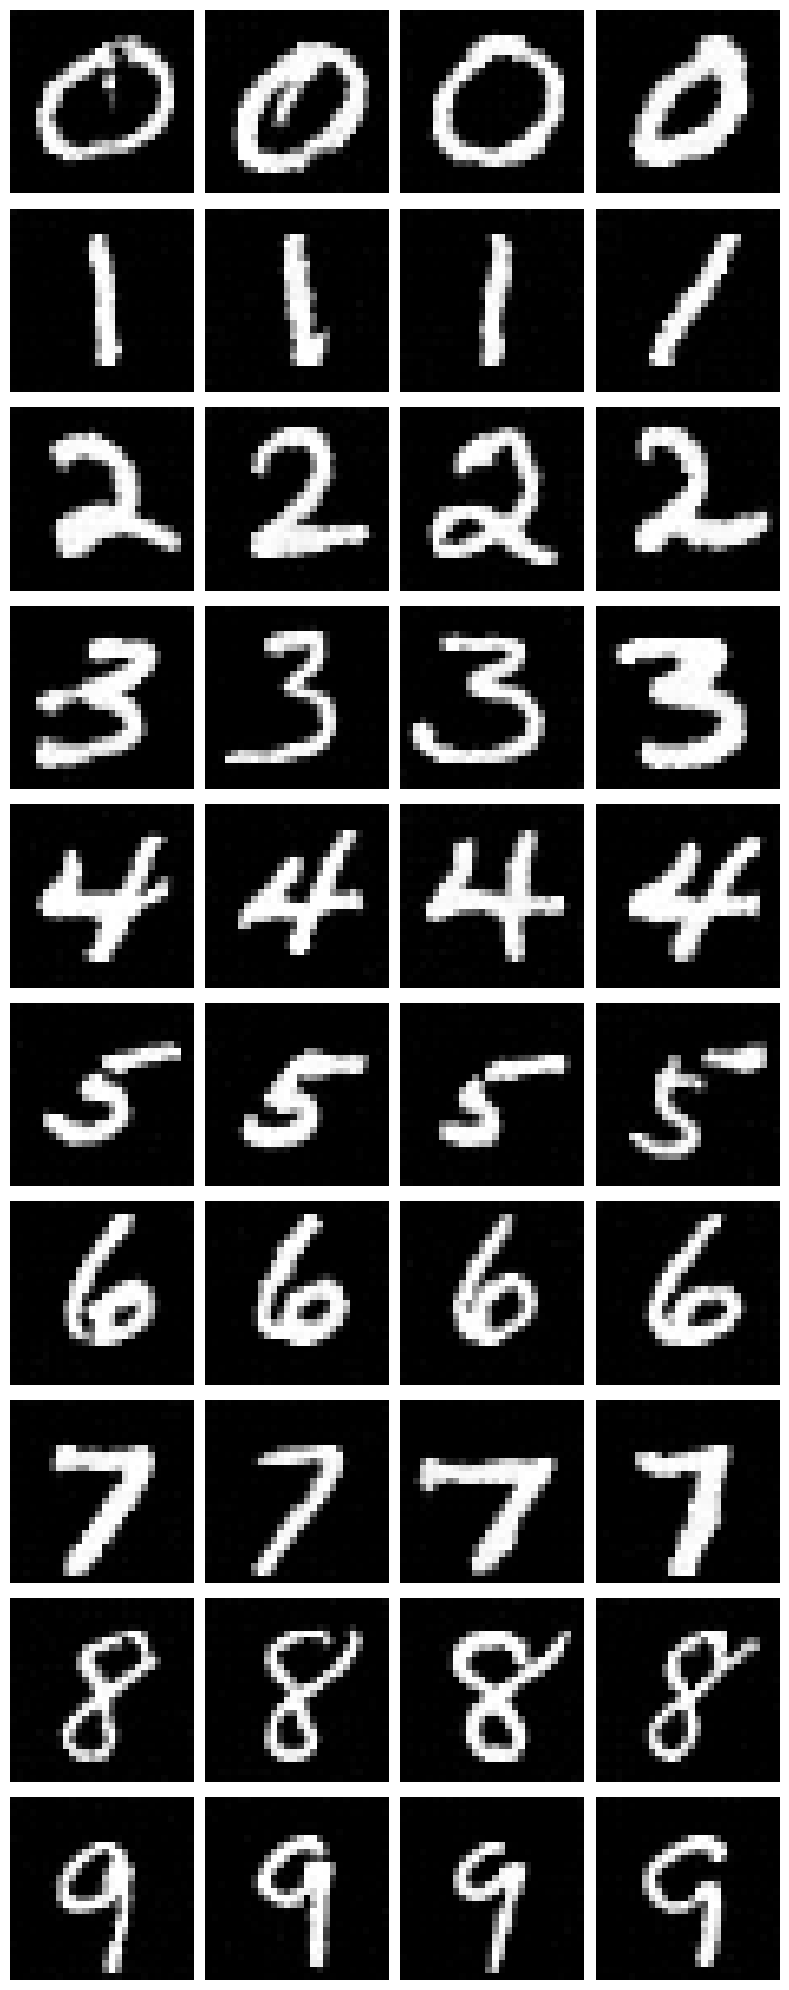

In [79]:
unet_epoch5_class = ClassConditionalUNet(in_channels=1, num_classes=num_classes, num_hiddens=64).to(device)
ddpm_model_epoch5_class = DDPM_Class(unet=unet_epoch5_class, p_uncond=0.1).to(device)
ddpm_model_epoch5_class.load_state_dict(torch.load('ddpm_class_epoch_5.pth', map_location=device))

unet_epoch20_class = ClassConditionalUNet(in_channels=1, num_classes=num_classes, num_hiddens=64).to(device)
ddpm_model_epoch20_class = DDPM_Class(unet=unet_epoch20_class, p_uncond=0.1).to(device)
ddpm_model_epoch20_class.load_state_dict(torch.load('ddpm_class_epoch_20.pth', map_location=device))

def generate_and_plot_class_samples(ddpm_model, img_wh=(28,28), num_samples_per_class=4, seed=0):
    ddpm_model.eval()
    num_classes = 10
    samples = []
    labels = []
    for cls in range(num_classes):
        c = torch.full((num_samples_per_class,), cls, dtype=torch.long, device=device)
        sample = ddpm_model.sample(c=c, img_wh=img_wh, seed=seed + cls)
        samples.append(sample)
        labels.extend([cls]*num_samples_per_class)
    samples = torch.cat(samples, dim=0)
    samples = samples.cpu().detach()
    samples = torch.clamp(samples, 0.0, 1.0)
    fig, axes = plt.subplots(num_classes, num_samples_per_class, figsize=(num_samples_per_class * 2, num_classes * 2))
    idx = 0
    for i in range(num_classes):
        for j in range(num_samples_per_class):
            axes[i, j].imshow(samples[idx,0,:,:], cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_ylabel(f"Class {i}", rotation=0, labelpad=30, size='large')
            idx +=1
    plt.tight_layout()
    plt.show()


print("Class-Conditioned Samples after 5 epochs:")
generate_and_plot_class_samples(ddpm_model_epoch5_class, num_samples_per_class=4)

print("Class-Conditioned Samples after 20 epochs:")
generate_and_plot_class_samples(ddpm_model_epoch20_class, num_samples_per_class=4)